# Early stage diabetes risk prediction dataset - Decision Tree

https://www.kaggle.com/datasets/yasserhessein/early-stage-diabetes-risk-prediction-dataset

### Import Libraries

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from statsmodels.stats.outliers_influence import variance_inflation_factor
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.tree import plot_tree
%matplotlib inline

### Read data

In [56]:
diabetes = pd.read_csv('diabetes_data_upload.csv')

### Feature Engeneering

In [58]:
# Transforme "Yes/No" into 1/0

for i in ['Polyuria','Polydipsia','sudden weight loss','weakness','Polyphagia','Genital thrush','visual blurring','Itching','Irritability','delayed healing','partial paresis','muscle stiffness','Alopecia','Obesity']:
    diabetes[i]=diabetes[i].map(dict(Yes=1, No=0))

diabetes['class']=diabetes['class'].map(dict(Positive=1, Negative=0))

diabetes = pd.get_dummies(data=diabetes, columns=['Gender'],drop_first=True).rename(columns={'Gender_Male':'isMale'})

### Define Features and Target

In [61]:
target = ['class']
features = [x for x in diabetes.columns if x not in target]

### Split train/test

In [62]:
X_train, X_test, y_train, y_test = train_test_split(diabetes[features], diabetes[target], test_size=0.33, random_state=42)

### Feature Selection using Boruta

In [74]:
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

feat_selector = BorutaPy(
    verbose=0,
    estimator=model,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)

feat_selector.fit(np.array(X_train), y_train.values.ravel())

cols_selected = feat_selector.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
cols_not_selected_boruta = list( np.setdiff1d( X_train.columns, cols_selected_boruta ) )

print(f'Features Selected: {cols_selected_boruta}')

Features Selected: ['Age', 'Polyuria', 'Polydipsia', 'Irritability', 'Alopecia', 'isMale']


### Grid Search using all the features

In [79]:
param_grid = {
    'max_depth':[1,2,3,4,5,8,16,32],
    'max_leaf_nodes':list(range(2, 20, 1)),
    'min_samples_split':[2,3,4,5,8,12,16,20]    
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
The best parameters are:  {'max_depth': 5, 'max_leaf_nodes': 16, 'min_samples_split': 2}


### Grid Search using boruta features 

In [80]:
param_grid = {
    'max_depth':[1,2,3,4,5,8,16,32],
    'max_leaf_nodes':list(range(2, 20, 1)),
    'min_samples_split':[2,3,4,5,8,12,16,20]    
}

grid_search_cv_boruta = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, verbose=1, cv=3)
grid_search_cv_boruta.fit(X_train[cols_selected_boruta], y_train)
print("The best parameters are: ", grid_search_cv_boruta.best_params_)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
The best parameters are:  {'max_depth': 8, 'max_leaf_nodes': 16, 'min_samples_split': 2}


### Fit and Pred using all features

In [91]:
tree_clf = DecisionTreeClassifier(random_state=42,  **grid_search_cv.best_params_)
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X=X_test)
acc_score    = accuracy_score (y_pred=y_pred, y_true=y_test)
prec_score   = precision_score(y_pred=y_pred, y_true=y_test, average='micro')
rec_score    = recall_score(y_pred=y_pred,y_true=y_test, average='micro')
print('Accuracy=%s' % (acc_score))
print('Precision=%s' % (prec_score))
print('Recall=%s' % (rec_score))


Accuracy=0.8953488372093024
Precision=0.8953488372093024
Recall=0.8953488372093024


### Fit and Pred using Boruta features

In [93]:
tree_clf_boruta = DecisionTreeClassifier(random_state=42,  **grid_search_cv_boruta.best_params_)
tree_clf_boruta.fit(X_train[cols_selected_boruta], y_train)

y_pred_boruta = grid_search_cv_boruta.predict(X=X_test[cols_selected_boruta])
acc_score    = accuracy_score (y_pred=y_pred_boruta, y_true=y_test)
prec_score   = precision_score(y_pred=y_pred_boruta, y_true=y_test, average='micro')
rec_score    = recall_score(y_pred=y_pred_boruta,y_true=y_test, average='micro')
print('Accuracy=%s' % (acc_score))
print('Precision=%s' % (prec_score))
print('Recall=%s' % (rec_score))

Accuracy=0.9476744186046512
Precision=0.9476744186046512
Recall=0.9476744186046512


### Visualize Tree all Features

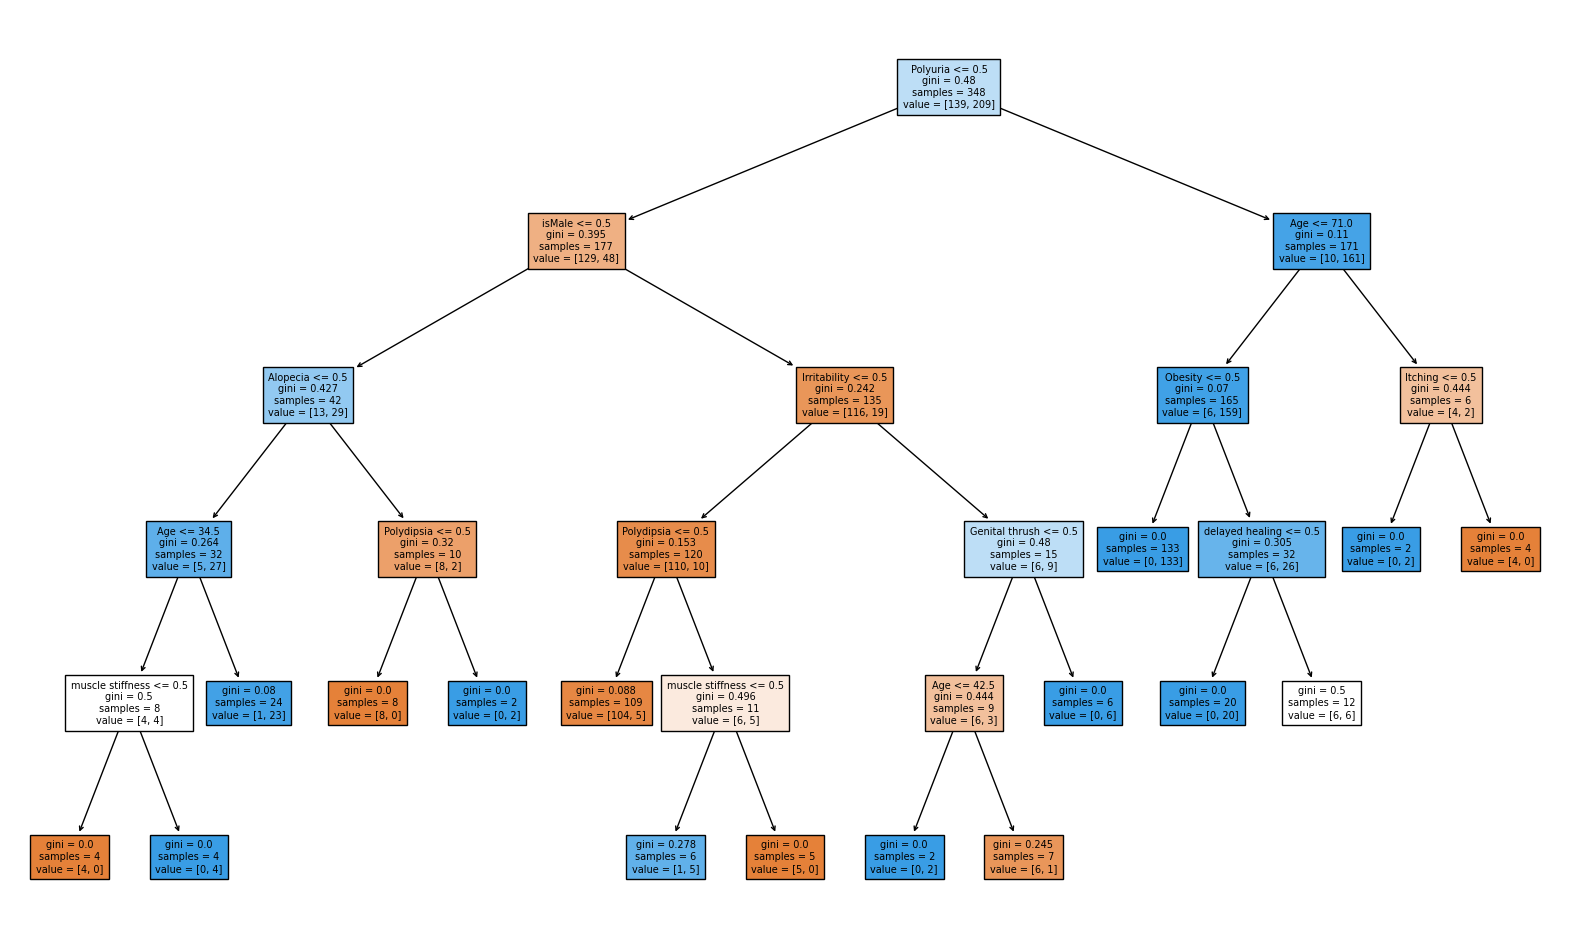

In [103]:
plt.figure(figsize=(20,12)) 
plot_tree(decision_tree=tree_clf,feature_names=features,filled=True,fontsize=7);
plt.show()

### Visualize Tree boruta Features

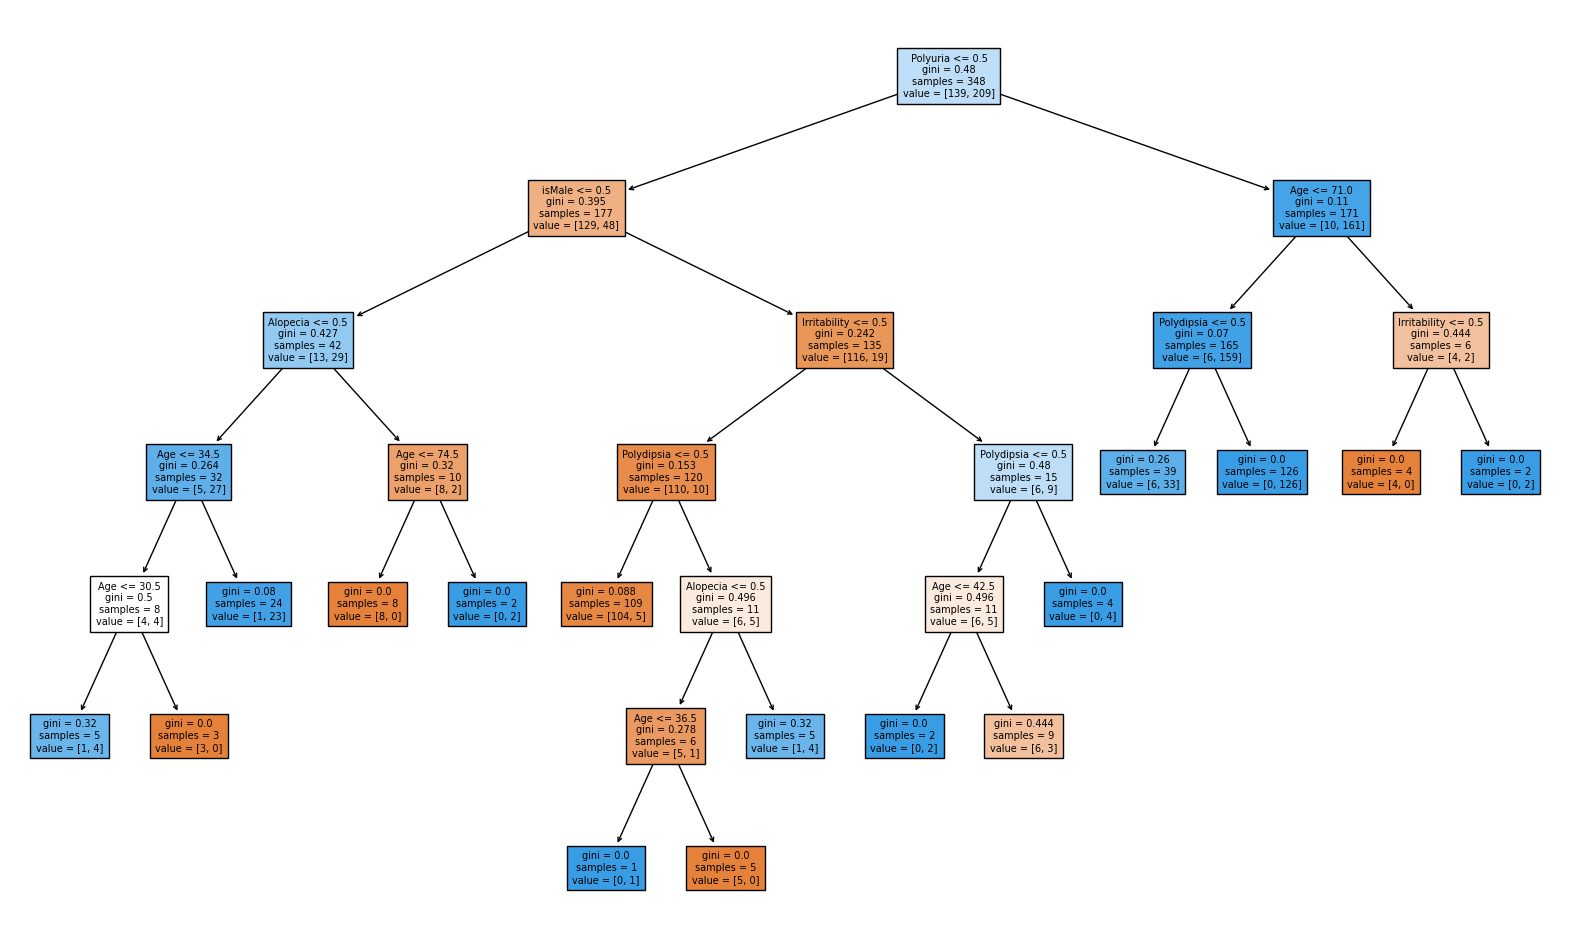

In [105]:
plt.figure(figsize=(20,12)) 
plot_tree(decision_tree=tree_clf_boruta,feature_names=cols_selected_boruta,filled=True,fontsize=7);
plt.show()